# Building a Book Writer with Web Research Capabilities

This notebook demonstrates how to create a system that researches a topic using web search, creates an outline, and then writes a book based on the gathered information. We'll use the SerperDevTool to perform internet searches and ensure our content is well-researched and factually accurate.

## Introduction

When creating informational content, having access to the latest information is crucial. By integrating web search capabilities, we can create an AI system that:

1. Researches any topic using real-time internet searches
2. Creates a structured outline based on that research
3. Writes informative content incorporating the gathered information
4. Saves the completed book to the filesystem

This approach ensures our content is factual, up-to-date, and well-sourced.

## Setting Up the Environment

First, let's install the necessary packages:

In [13]:
!pip install crewai crewai-tools

python(5789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 1.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.50.1 requires tokenizers<0.22,>=0.21, but you have tokenizers 0.20.3 which is incompatible.


Now, let's import the required modules:

In [14]:
import os
import json
from datetime import datetime
from crewai import Agent, Task, Crew, Process, LLM
from crewai_tools import SerperDevTool

## Setting Up API Keys

The SerperDevTool requires an API key from Serper.dev. Let's set up our environment variable:

In [ ]:
# Set your Serper API key here
import os
os.environ["SERPER_API_KEY"] = ""  # Replace with your actual API key

# Or load it from .env file
# from dotenv import load_dotenv
# load_dotenv()

## Defining Our Agents and Tools

Now, let's create our specialized agents and tools:

In [ ]:
# Define our LLM
llm = LLM(model="ollama/gemma3:4b")

# Create our web search tool
from typing import Type
from crewai.tools import BaseTool
from pydantic import BaseModel, Field
import os
import ssl
import requests
from dotenv import load_dotenv

ssl._create_default_https_context = ssl._create_unverified_context

class BrightDataWebSearchToolInput(BaseModel):
    """Input schema for BrightDataWebSearchTool."""
    title: str = Field(..., description="Topic of the book to write about and search Google for.")

class BrightDataWebSearchTool(BaseTool):
    name: str = "Web Search Tool"
    description: str = "Use this tool to search Google and retrieve the top search results."
    args_schema: Type[BaseModel] = BrightDataWebSearchToolInput

    def _run(self, title: str) -> str:
        
        host = 'brd.superproxy.io'
        port = 33335

        username = os.getenv("BRIGHDATA_USERNAME")
        password = os.getenv("BRIGHDATA_PASSWORD")        

        proxy_url = f'http://{username}:{password}@{host}:{port}'

        proxies = {
            'http': proxy_url,
            'https': proxy_url
        }

        query = "+".join(title.split(" "))

        url = f"https://www.google.com/search?q={query}&brd_json=1&num=50"
        response = requests.get(url, proxies=proxies, verify=False)

        return response.json()['organic']


search_tool = BrightDataWebSearchTool()
# Create a researcher agent with search capabilities
researcher = Agent(
    role="Internet Researcher",
    goal="Find the most accurate, up-to-date information on topics using web searches",
    backstory="""You are a highly skilled research specialist who excels at finding
    and synthesizing information from multiple online sources. You're known for your
    ability to quickly identify reliable sources and extract key information.""",
    llm=llm,
    verbose=True,
    tools=[search_tool]
)

# Create an outliner agent
outliner = Agent(
    role="Content Strategist",
    goal="Organize research findings into clear, logical book outlines",
    backstory="""You are an experienced content strategist who specializes in
    structuring information for maximum clarity and impact. You excel at identifying
    key themes and creating organizational frameworks that enhance understanding.""",
    llm=llm,
    verbose=True
)

# Create a writer agent
writer = Agent(
    role="Content Writer",
    goal="Transform outlines and research into engaging, informative book content",
    backstory="""You are a talented writer with a gift for explaining complex topics
    in accessible, engaging language. You excel at incorporating research into flowing
    narratives while maintaining factual accuracy.""",
    llm=llm,
    verbose=True
)

## Creating a Function to Save the Book

Let's create a function to save our book to the filesystem:

In [17]:
def save_book_to_file(content, title):
    """Save book content to a markdown file."""
    # Clean the title for use as a filename
    clean_title = title.lower().replace(" ", "_").replace(":", "").replace("?", "").replace("!", "")
    
    # Ensure the filename has .md extension
    if not clean_title.endswith(".md"):
        clean_title += ".md"
    
    # Create the books directory if it doesn't exist
    books_dir = os.path.join(os.getcwd(), 'books')
    os.makedirs(books_dir, exist_ok=True)
    
    # Create the full file path
    file_path = os.path.join(books_dir, clean_title)
    
    # Write the content to the file
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(content)
    
    return f"Book saved to {file_path}"

## Creating Our Tasks

Now, let's define the tasks for our book writing process:

In [18]:
# Function to get the topic from user input
def get_book_topic():
    return input("Enter a topic for your book: ")

# We'll use this topic in our tasks
book_topic = get_book_topic()

# Create a web research task
research_task = Task(
    description=f"""Conduct comprehensive web research on '{book_topic}'.
    
    Use the search tool to gather accurate, up-to-date information on:
    1. Key concepts and definitions related to {book_topic}
    2. Historical development or background
    3. Current state or applications
    4. Major subtopics or categories
    5. Important debates or perspectives
    6. Future trends or developments
    
    For each search, extract the most relevant information and organize it by subtopic.
    Keep track of the sources for each piece of information.
    
    Your final research should be comprehensive enough to serve as the foundation for a book
    with 2 chapters maximum.""",
    expected_output="""A comprehensive research document containing:
    1. Key information organized by subtopics
    2. Source citations for important facts
    3. Quotes from authoritative sources (with attribution)
    4. A suggested breakdown of 1-2 main chapters based on the research""",
    agent=researcher
)

# Create an outline task
outline_task = Task(
    description=f"""Based on the research provided, create a detailed outline for a book on '{book_topic}'.
    
    The book should have no more than 2 chapters and should cover the most important aspects 
    of the topic based on the research.
    
    Your outline should include:
    1. A compelling title for the book
    2. An introduction section outlining the book's purpose and scope
    3. 1-2 chapters with clear titles
    4. 3-5 sections for each chapter with brief descriptions
    5. A conclusion section
    
    Structure the outline logically, ensuring a smooth flow of information from basic 
    concepts to more advanced or specific content.
    
    Format the outline as JSON with the following structure:
    {{
        "title": "Book Title",
        "introduction": "Brief description of the introduction",
        "chapters": [
            {{
                "title": "Chapter 1 Title",
                "sections": [
                    {{"title": "Section 1 Title", "description": "Brief description"}},
                    {{"title": "Section 2 Title", "description": "Brief description"}}
                ]
            }}
        ],
        "conclusion": "Brief description of the conclusion"
    }}""",
    expected_output="A JSON-formatted outline for a book with 1-2 chapters",
    agent=outliner,
    context=[research_task]  # Give the outliner access to the research
)

# Create a writing task
writing_task = Task(
    description=f"""Based on the research and outline provided, write a complete book on '{book_topic}'.
    
    Follow the structure in the outline, ensuring that:
    1. The content is accurate and based on the research
    2. The writing is clear, engaging, and accessible
    3. Each section flows logically to the next
    4. The book maintains a consistent tone and style
    5. Important facts are included from the research
    
    Format the book with proper Markdown:
    - Use # for the book title
    - Use ## for chapter titles
    - Use ### for section titles
    - Use appropriate formatting for emphasis, lists, etc.
    
    The final book should be ready for direct saving as a Markdown file.""",
    expected_output="A complete book in Markdown format, following the outline structure",
    agent=writer,
    context=[research_task, outline_task]  # Writer has access to both research and outline
)

## Creating the Book Writing Process

Now, let's put everything together in a function that executes the book writing process:

In [19]:
def write_book_with_web_research(topic):
    """Complete book writing process with web research."""
    print(f"Starting book writing process on topic: '{topic}'")
    
    # Create the agents and tasks with the specified topic
    global book_topic
    book_topic = topic
    
    # Create a crew to manage the book writing process
    book_crew = Crew(
        agents=[researcher, outliner, writer],
        tasks=[research_task, outline_task, writing_task],
        verbose=True,
        process=Process.sequential
    )
    
    # Execute the crew
    print("\nStarting the research and writing process...")
    result = book_crew.kickoff()
    
    # Extract the book title from the outline task result
    outline_result = outline_task.output.raw
    try:
        # Find the JSON in the outline result
        json_start = outline_result.find('{')
        json_end = outline_result.rfind('}') + 1
        if json_start >= 0 and json_end > json_start:
            outline_json = outline_result[json_start:json_end]
            outline_data = json.loads(outline_json)
            book_title = outline_data.get("title", topic)
        else:
            # Fallback if JSON extraction fails
            book_title = f"Book on {topic}"
    except Exception as e:
        print(f"Error extracting book title: {e}")
        book_title = f"Book on {topic}"
    
    # Get the final book content
    book_content = result.raw
    
    # Add metadata
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metadata = f"\n\n---\nGenerated on {timestamp} using CrewAI with web research"
    book_content += metadata
    
    # Save the book to a file
    file_path = save_book_to_file(book_content, book_title)
    
    print(f"\nBook writing completed!")
    print(file_path)
    
    return {
        "title": book_title,
        "file_path": file_path,
        "content_preview": book_content[:500] + "..." if len(book_content) > 500 else book_content
    }

## Executing the Process

Now, let's run our book writing process:

Starting book writing process on topic: 'crewAi tools'

Starting the research and writing process...


╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 2823145f-bf37-4fe4-93dc-6acdb5d2c641                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...

🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: In Progress

# Agent: Internet Researcher
## Task: Conduct comprehensive web research on 'crewAI tools'.
    
    Use the search tool to gather accurate, up-to-date information on:
    1. Key concepts and definitions related to crewAI tools
    2. Historical development or background
    3. Current state or applications
    4. Major subtopics or categories
    5. Important debates or perspectives
    6. Future trends or developments
    
    For each search, extract the most relevant information and organize it by subtopic.
    Keep track of the sources for each piece of information.
    
    Your final research should be comprehensive enough to serve as the foundation for a book
    with 2 chapters maximum.


🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: In Progress
        └── 🧠 Thinking...

🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: In Progress

🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: In Progress
        └── 🔧 Using Web Search Tool (1)

/opt/anaconda3/envs/getting_started_llmops/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'brd.superproxy.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: In Progress
        └── 🔧 Used Web Search Tool (1)



# Agent: Internet Researcher
## Thought: Okay, let's start by gathering information on 'crewAI tools'. I need to perform a series of web searches to cover the requested subtopics. I'll start with a broad search to get an overview and then refine my searches based on the initial results.
## Using tool: Web Search Tool
## Tool Input: 
"{\"title\": \"crewAI tools\"}"
## Tool Output: 
[{'link': 'https://docs.crewai.com/concepts/tools', 'display_link': 'https://docs.crewai.com › concepts › tools', 'title': 'Tools', 'description': 'CrewAI tools empower agents with capabilities ranging from web searching and data analysis to collaboration and delegating tasks among coworkers. This ...', 'extensions': [{'type': 'site_link', 'text': 'Key Characteristics of Tools', 'link': 'https://docs.crewai.com/concepts/tools#key-characteristics-of-tools', 'rank': 1}, {'type': 'site_link', 'text': 'Using CrewAI Tools', 'link': 'https://docs.crewai.com/concepts/tools#using-crewai-tools', 'rank': 2}, {'type':
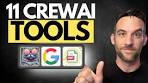
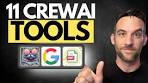

🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: In Progress
        ├── 🔧 Used Web Search Tool (1)
        └── 🧠 Thinking...

🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: In Progress
        └── 🔧 Used Web Search Tool (1)

🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: In Progress
        ├── 🔧 Used Web Search Tool (1)
        └── 🧠 Thinking...

🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: In Progress
        └── 🔧 Used Web Search Tool (1)



# Agent: Internet Researcher
## Final Answer: 
CrewAI is an open-source framework for orchestrating role-playing and autonomous AI agents. It helps create collaborative AI agents to solve complex problems by allowing multiple AI agents to interact and work together. The framework provides tools for defining roles, setting up environments, and managing the flow of information between agents. It’s particularly useful for scenarios requiring complex reasoning, problem-solving, and creative collaboration.




🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Status: Executing Task...
    └── 🤖 Agent: Internet Researcher
            Status: ✅ Completed
        └── 🔧 Used Web Search Tool (1)

🚀 Crew: crew
└── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
       Assigned to: Internet Researcher
       Status: ✅ Completed
    └── 🤖 Agent: Internet Researcher
            Status: ✅ Completed
        └── 🔧 Used Web Search Tool (1)

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: fa00a864-6122-4cc4-9d5a-3e728596047f                                                                     │
│  Agent: Internet Researcher                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
└── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
└── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
       Status: Executing Task...
    └── 🤖 Agent: Content Strategist
            Status: In Progress

# Agent: Content Strategist
## Task: Based on the research provided, create a detailed outline for a book on 'crewAI tools'.
    
    The book should have no more than 2 chapters and should cover the most important aspects 
    of the topic based on the research.
    
    Your outline should include:
    1. A compelling title for the book
    2. An introduction section outlining the book's purpose and scope
    3. 1-2 chapters with clear titles
    4. 3-5 sections for each chapter with brief descriptions
    5. A conclusion section
    
    Structure the outline logically, ensuring a smooth flow of information from basic 
    concepts to more advanced or specific content.
    
    Format the outline as JSON with the following structure:
    {
        "title": "Book Title",
        "introduction": "Brief description of the introduction",
        "chapters": [
            {
                "title": "Chapter 1 Title",
                "sections": [
                    {"title": "Section 1 

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
└── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
       Status: Executing Task...
    └── 🤖 Agent: Content Strategist
            Status: In Progress
        └── 🧠 Thinking...

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
└── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
       Status: Executing Task...
    └── 🤖 Agent: Content Strategist
            Status: In Progress



# Agent: Content Strategist
## Final Answer: 
```json
{
  "title": "CrewAI Tools: Orchestrating Collaborative AI Agents",
  "introduction": "This book provides a comprehensive introduction to CrewAI, an open-source framework designed for building and managing collaborative AI agents. It explores the core concepts, tools, and techniques for leveraging CrewAI to tackle complex problems requiring reasoning, problem-solving, and creative collaboration. The book is aimed at developers, researchers, and anyone interested in exploring the potential of orchestrating autonomous AI agents.",
  "chapters": [
    {
      "title": "Understanding CrewAI: Core Concepts and Architecture",
      "sections": [
        {"title": "What is CrewAI?", "description": "An overview of the CrewAI framework, its purpose, and key features. Explains the core concept of orchestrating AI agents."},
        {"title": "Roles and Agent Definition", "description": "Details how to define roles for AI agents within the C

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
└── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
       Status: Executing Task...
    └── 🤖 Agent: Content Strategist
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
└── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
       Assigned to: Content Strategist
       Status: ✅ Completed
    └── 🤖 Agent: Content Strategist
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 0894ef31-0356-40c4-8d88-96f923bcff80                                                                     │
│  Agent: Content Strategist                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
├── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
│      Assigned to: Content Strategist
│      Status: ✅ Completed
│   └── 🤖 Agent: Content Strategist
│           Status: ✅ Completed
└── 📋 Task: 97028e6d-dbb5-4f1a-b092-145d210215c0
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
├── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
│      Assigned to: Content Strategist
│      Status: ✅ Completed
│   └── 🤖 Agent: Content Strategist
│           Status: ✅ Completed
└── 📋 Task: 97028e6d-dbb5-4f1a-b092-145d210215c0
       Status: Executing Task...
    └── 🤖 Agent: Content Writer
            Status: In Progress

# Agent: Content Writer
## Task: Based on the research and outline provided, write a complete book on 'crewAI tools'.
    
    Follow the structure in the outline, ensuring that:
    1. The content is accurate and based on the research
    2. The writing is clear, engaging, and accessible
    3. Each section flows logically to the next
    4. The book maintains a consistent tone and style
    5. Important facts are included from the research
    
    Format the book with proper Markdown:
    - Use # for the book title
    - Use ## for chapter titles
    - Use ### for section titles
    - Use appropriate formatting for emphasis, lists, etc.
    
    The final book should be ready for direct saving as a Markdown file.


🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
├── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
│      Assigned to: Content Strategist
│      Status: ✅ Completed
│   └── 🤖 Agent: Content Strategist
│           Status: ✅ Completed
└── 📋 Task: 97028e6d-dbb5-4f1a-b092-145d210215c0
       Status: Executing Task...
    └── 🤖 Agent: Content Writer
            Status: In Progress
        └── 🧠 Thinking...

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
├── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
│      Assigned to: Content Strategist
│      Status: ✅ Completed
│   └── 🤖 Agent: Content Strategist
│           Status: ✅ Completed
└── 📋 Task: 97028e6d-dbb5-4f1a-b092-145d210215c0
       Status: Executing Task...
    └── 🤖 Agent: Content Writer
            Status: In Progress



# Agent: Content Writer
## Final Answer: 
```markdown
# CrewAI Tools: Orchestrating Collaborative AI Agents

## Introduction

This book provides a comprehensive introduction to CrewAI, an open-source framework designed for building and managing collaborative AI agents. It explores the core concepts, tools, and techniques for leveraging CrewAI to tackle complex problems requiring reasoning, problem-solving, and creative collaboration. The book is aimed at developers, researchers, and anyone interested in exploring the potential of orchestrating autonomous AI agents.

## Chapter 1: Understanding CrewAI: Core Concepts and Architecture

### What is CrewAI?

CrewAI is an open-source framework that enables the orchestration of role-playing and autonomous AI agents. At its core, it provides the tools necessary to build systems where multiple AI agents can interact and work together to solve complex problems. The framework’s primary purpose is to facilitate collaborative AI, allowing agents 

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
├── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
│      Assigned to: Content Strategist
│      Status: ✅ Completed
│   └── 🤖 Agent: Content Strategist
│           Status: ✅ Completed
└── 📋 Task: 97028e6d-dbb5-4f1a-b092-145d210215c0
       Status: Executing Task...
    └── 🤖 Agent: Content Writer
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: fa00a864-6122-4cc4-9d5a-3e728596047f
│      Assigned to: Internet Researcher
│      Status: ✅ Completed
│   └── 🤖 Agent: Internet Researcher
│           Status: ✅ Completed
│       └── 🔧 Used Web Search Tool (1)
├── 📋 Task: 0894ef31-0356-40c4-8d88-96f923bcff80
│      Assigned to: Content Strategist
│      Status: ✅ Completed
│   └── 🤖 Agent: Content Strategist
│           Status: ✅ Completed
└── 📋 Task: 97028e6d-dbb5-4f1a-b092-145d210215c0
       Assigned to: Content Writer
       Status: ✅ Completed
    └── 🤖 Agent: Content Writer
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 97028e6d-dbb5-4f1a-b092-145d210215c0                                                                     │
│  Agent: Content Writer                                                                                          │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 2823145f-bf37-4fe4-93dc-6acdb5d2c641                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


Book writing completed!
Book saved to /Users/saisuryamadhav/Documents/Personal/CrewAI-Experiments/notebooks/books/crewai_tools_orchestrating_collaborative_ai_agents.md

--- Book Information ---
Title: CrewAI Tools: Orchestrating Collaborative AI Agents
Saved to: Book saved to /Users/saisuryamadhav/Documents/Personal/CrewAI-Experiments/notebooks/books/crewai_tools_orchestrating_collaborative_ai_agents.md

Preview:
```markdown
# CrewAI Tools: Orchestrating Collaborative AI Agents

## Introduction

This book provides a comprehensive introduction to CrewAI, an open-source framework designed for building and managing collaborative AI agents. It explores the core concepts, tools, and techniques for leveraging CrewAI to tackle complex problems requiring reasoning, problem-solving, and creative collaboration. The book is aimed at developers, researchers, and anyone interested in exploring the potential of orches...


In [20]:
# Get a topic from the user
topic = input("What topic would you like a book on? ")

# Run the book writing process
book_info = write_book_with_web_research(topic)

# Print information about the generated book
print("\n--- Book Information ---")
print(f"Title: {book_info['title']}")
print(f"Saved to: {book_info['file_path']}")
print("\nPreview:")
print(book_info['content_preview'])

## Complete Processing Example

Let's run through the complete process for a sample topic like "Machine Learning for Beginners":

In [21]:
# Example execution with a specific topic
# sample_book = write_book_with_web_research("Machine Learning for Beginners")

## How the Process Works

Let's explain how this web research-based book writing process works:

1. **Web Research**: The researcher agent uses the SerperDevTool to perform searches on the topic, gathering the most relevant and up-to-date information from across the internet.

2. **Outline Creation**: The outliner agent analyzes the research and creates a structured outline for the book, organizing the information into logical chapters and sections.

3. **Content Writing**: The writer agent takes the research and outline to create engaging, informative content that accurately reflects the gathered information.

4. **Book Saving**: The completed book is saved to the filesystem as a Markdown file, ready for viewing or further editing.

This approach combines the power of web search with the creative and organizational capabilities of AI agents, resulting in informative content grounded in real-world information.

## Extending the System

This system could be extended in several ways:

1. **Adding a Fact-Checker Agent**: Create an agent that verifies facts and checks for accuracy.

2. **Incorporating Image Generation**: Add tools to generate relevant images or diagrams.

3. **Adding Citations**: Enhance the writing to include formal citations of sources.

4. **Interactive Feedback**: Allow for human review and feedback during the process.

By leveraging the combination of web search and collaborative AI agents, this system demonstrates how complex creative and informational tasks can be automated while maintaining quality and accuracy.

## Conclusion

In this notebook, we've built a system that:

1. Uses web search to gather accurate, up-to-date information on any topic
2. Creates a structured outline based on the research
3. Writes a comprehensive book with up to 2 chapters
4. Saves the completed book as a Markdown file

This demonstrates the power of combining web search capabilities with the collaborative agent framework of CrewAI to create informative, well-researched content.